<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-network" data-toc-modified-id="Load-network-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Load network</a></span></li><li><span><a href="#Load-cases" data-toc-modified-id="Load-cases-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Load cases</a></span></li></ul></li></ul></li></ul></div>

In [1]:
using Pkg; Pkg.activate()

using DataFrames, CSV
using Convex, ECOS
using Distributions, Random  
using LightGraphs  
using Plots

using SparseArrays
using Base.Iterators: product

using Revise
using CarbonNetworks

ECOS_QUIET = () -> ECOS.Optimizer(verbose=false)

#1 (generic function with 1 method)

# Load data

### Load network

In [21]:
DATAPATH = "/Users/degleris/Data/carbon_networks/"
A, gmax, pmax, f, G, nodes = parse_network_data(DATAPATH; num_generators=10)
n = length(gmax)
m = length(pmax)

# Remove infinite capacities
pmax[pmax .== Inf] .= 3*maximum(gmax)

normalization = mean(gmax)
gmax /= normalization
pmax /= normalization

@show n, m;

agg_nodes, B = create_generation_map(nodes);

(n, m) = (3116, 3207)


In [22]:
size(A)

(3116, 3207)

### Load cases

In [23]:
file_names = joinpath.(joinpath(DATAPATH, "TRAIN"), readdir(joinpath(DATAPATH, "TRAIN")))

cases = []
for file in file_names   
    d, g, case = load_case(file, agg_nodes, B, nodes)
    d = d/normalization
    g = g/normalization
    push!(cases, (d=d, g=g, case=case))
end

train_cases = cases[1:500]
test_cases = cases[501:end];

In [31]:
# Algorithm parameters
step_size = 5.0
max_iter = 100
batch_size = 8
test_batch_size = 2

2

In [26]:
Random.seed!(4)

# Initialize estimated costs
f̂ = rand(Exponential(5), n) .+ 2

train_loss_hist = []
test_loss_hist = []
grad_hist = []

Any[]

In [32]:
@time for iter in 1:max_iter
    print("$(iter)-")
    # Evaluate loss and gradient
    sample = rand(1:length(train_cases), batch_size)
    L, df = stochastic_loss_and_grad(f̂, B, train_cases, pmax, gmax, A, sample)
    
    push!(train_loss_hist, L)
    push!(grad_hist, df)
    
    # Compute test loss
    sample = rand(1:length(test_cases), test_batch_size)
    L_test, _ = stochastic_loss_and_grad(f̂, B, test_cases, pmax, gmax, A, sample)
    
    push!(test_loss_hist, L_test)
    
    # Take projected gradient step
    η = min(norm(df), step_size)
    f̂ = max.(f̂ - η*(df/norm(df)), 0)
end

println("Completed $(max_iter) iterations.")

1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-4206.457366 seconds (284.32 M allocations: 856.143 GiB, 2.06% gc time)
Completed 100 iterations.


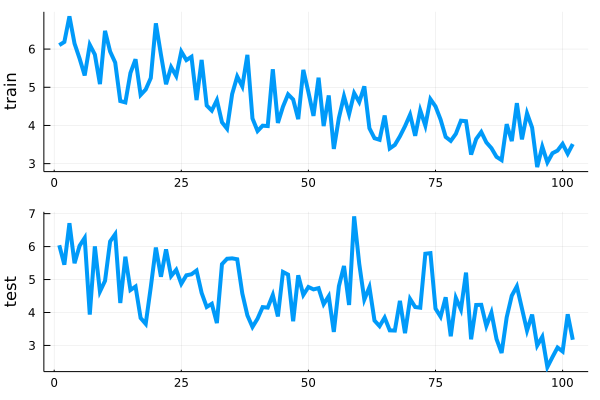

In [34]:
theme(:default, lw=4, label=nothing)

plot(
    plot(train_loss_hist, ylabel="train"),
    plot(test_loss_hist, ylabel="test"),
    layout=(2, 1)
)